# Dataset Description

We have used PlantVillage dataset, which contains around 54k leaf images. There are different types of plants and diseases.They have also provided prerpocessed images like grayscale and segmented images. 

We will perform binary classification, whether given leaf has a disease or not. We will use original image data

# Import Libraries

In [1]:
!pip install basic_image_eda
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import cv2
import traceback
import sys

from basic_image_eda import BasicImageEDA
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.models import  save_model

# Exploratory Data Analysis

In [2]:
data_dir = r"/kaggle/input/plantvillage-dataset/color/"

### View Sample Images

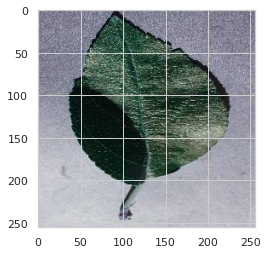

In [3]:
img = cv2.imread(data_dir+"Apple___healthy/0055dd26-23a7-4415-ac61-e0b44ebfaf80___RS_HL 5672.JPG")
plt.imshow(img)

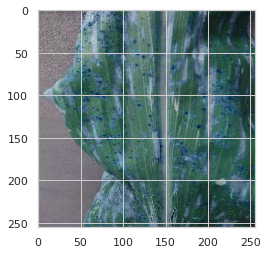

In [4]:
img = cv2.imread(data_dir+"Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/0a403456-5c5e-4aad-aa89-a118175c6ddd___RS_GLSp 4501.JPG")
plt.imshow(img)

In [5]:
BasicImageEDA.explore(data_dir)


found 1502 images.


  1%|▏         | 19/1502 [00:00<00:08, 179.33it/s]

Using 2 threads. (max:2)



100%|██████████| 1502/1502 [00:07<00:00, 195.75it/s]



*--------------------------------------------------------------------------------------*
number of images                         |  1502

dtype                                    |  uint8
channels                                 |  [3, 4]
extensions                               |  ['jpg', 'png', 'jpeg']

min height                               |  256
max height                               |  256
mean height                              |  256.0
median height                            |  256

min width                                |  256
max width                                |  256
mean width                               |  256.0
median width                             |  256

mean height/width ratio                  |  1.0
median height/width ratio                |  1.0
recommended input size(by mean)          |  [256 256] (h x w, multiples of 8)
recommended input size(by mean)          |  [256 256] (h x w, multiples of 16)
recommended input size(by mean)          |  [256

{'dtype': 'uint8',
 'channels': [3, 4],
 'extensions': ['jpg', 'png', 'jpeg'],
 'min_h': 256,
 'max_h': 256,
 'mean_h': 256.0,
 'median_h': 256,
 'min_w': 256,
 'max_w': 256,
 'mean_w': 256.0,
 'median_w': 256,
 'mean_hw_ratio': 1.0,
 'median_hw_ratio': 1.0,
 'rec_hw_size_8': array([256, 256]),
 'rec_hw_size_16': array([256, 256]),
 'rec_hw_size_32': array([256, 256]),
 'mean': array([0.4598716, 0.5703862, 0.4256738], dtype=float32),
 'std': array([0.21605766, 0.22352958, 0.22219926], dtype=float32)}

### Counting Category Wise Images

In [6]:
category_count = []

for root, dirs, files in os.walk(data_dir):
    for dir_path in dirs:
        category_count.append((dir_path, len(os.listdir(root+os.sep+dir_path))))

In [7]:
count_df = pd.DataFrame(category_count, columns=['Category', 'Count'])
count_df.head(10)

,Category,Count
0,Tomato___Late_blight,1909
1,Tomato___healthy,1591
2,Grape___healthy,423
3,Orange___Haunglongbing_(Citrus_greening),5507
4,Soybean___healthy,5090
5,Squash___Powdery_mildew,1835
6,Potato___healthy,152
7,Corn_(maize)___Northern_Leaf_Blight,985
8,Tomato___Early_blight,1000
9,Tomato___Septoria_leaf_spot,1771


In [8]:
total_images = count_df['Count'].sum()
total_images

54305

In [9]:
len(count_df)

38

# Visualize Category Wise Count

[]

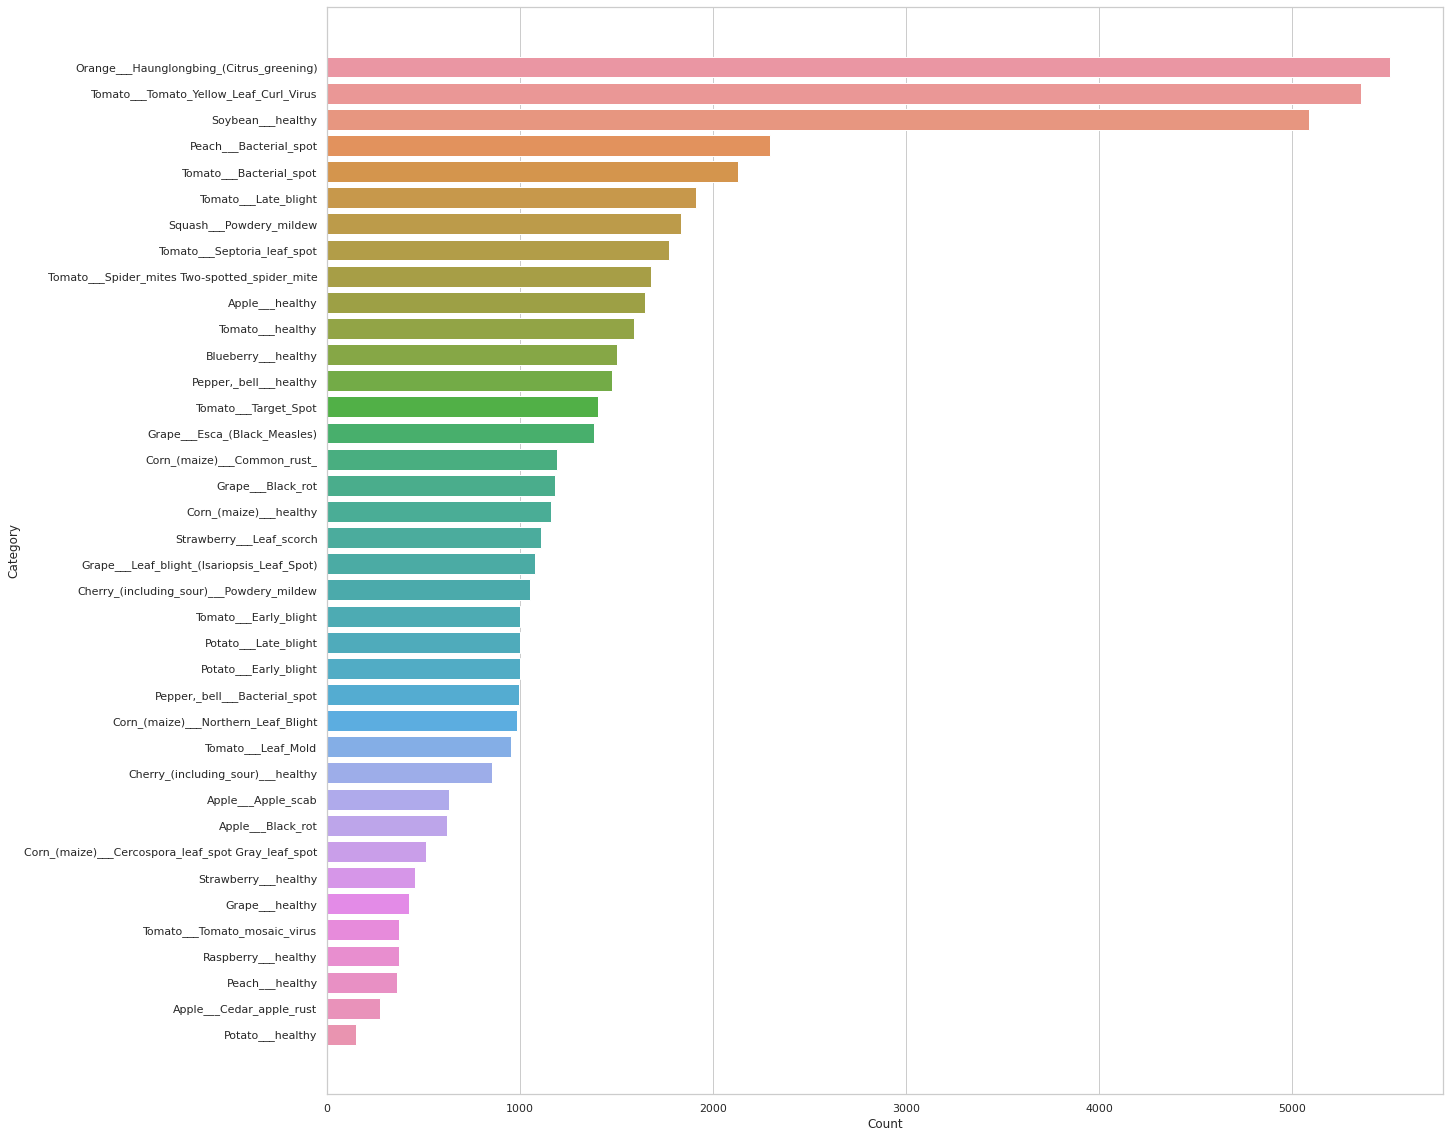

In [10]:
count_df = count_df.sort_values(by='Count', ascending=False)
plt.figure(figsize=(20,20))
sns.barplot(x="Count", y="Category", data=count_df)
plt.plot()

In [11]:
healthy_images_count = count_df[count_df['Category'].str.endswith("healthy")]['Count'].sum()
healthy_images_count

15084

In [12]:
disease_images_count = total_images - healthy_images_count
disease_images_count

39221

### Compare Healthy and Unhealthy image counts

[]

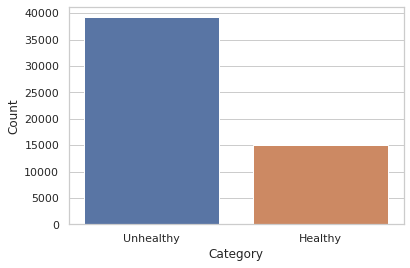

In [13]:
temp_df = pd.DataFrame(data=[("Unhealthy", disease_images_count), ("Healthy", healthy_images_count)], columns=['Category', 'Count'])
sns.barplot(y="Count",x="Category", data=temp_df)
plt.plot()

#### Observation
We have imabalanced data for healthy abd unhealthy leaves, so we will train on around 10k images each.

In [14]:
healthy_cat = len(count_df[count_df['Category'].str.endswith('healthy')])
print("healthy_cat",healthy_cat)
print("unhealthy_cat",38 - healthy_cat)

healthy_cat 12
unhealthy_cat 26


### Build File Path DataFrame

In [15]:
path_data = []

for root, dirs, files in os.walk(r"/kaggle/input/plantvillage-dataset/color"):
    for d in dirs:
        is_healthy = 1 if d.endswith("healthy") else 0
        leaf_type = d[:d.index("__")]
        
        parent = root+os.sep+d+os.sep
        
        for f in os.listdir(parent):
            path_data.append((leaf_type, is_healthy, d, parent+f))
            
path_df = pd.DataFrame(data=path_data, columns=['Leaf Type', 'Is Healthy', 'Category', 'Image Path'])
path_df.head(10)

,Leaf Type,Is Healthy,Category,Image Path
0,Tomato,0,Tomato___Late_blight,/kaggle/input/plantvillage-dataset/color/Tomat...
1,Tomato,0,Tomato___Late_blight,/kaggle/input/plantvillage-dataset/color/Tomat...
2,Tomato,0,Tomato___Late_blight,/kaggle/input/plantvillage-dataset/color/Tomat...
3,Tomato,0,Tomato___Late_blight,/kaggle/input/plantvillage-dataset/color/Tomat...
4,Tomato,0,Tomato___Late_blight,/kaggle/input/plantvillage-dataset/color/Tomat...
5,Tomato,0,Tomato___Late_blight,/kaggle/input/plantvillage-dataset/color/Tomat...
6,Tomato,0,Tomato___Late_blight,/kaggle/input/plantvillage-dataset/color/Tomat...
7,Tomato,0,Tomato___Late_blight,/kaggle/input/plantvillage-dataset/color/Tomat...
8,Tomato,0,Tomato___Late_blight,/kaggle/input/plantvillage-dataset/color/Tomat...
9,Tomato,0,Tomato___Late_blight,/kaggle/input/plantvillage-dataset/color/Tomat...


### Get Healthy Images Category Wise

In [16]:
max_samples_per_cat = 10000
replace = False

In [17]:
h_count = max_samples_per_cat // healthy_cat  
uh_count = max_samples_per_cat // (38 - healthy_cat)

new_data = []

for name, group in path_df.groupby(['Is Healthy', 'Category'], as_index=False):
    is_healthy, cat = name
    
    if is_healthy == 1:
        records = h_count 
    else:
        records = uh_count 
    
    for idx, row in group[:records].iterrows():
        new_data.append((is_healthy, cat, row['Image Path']))
        
new_df = pd.DataFrame(data=new_data, columns=['Is Healthy','Category', "Image Path"])
new_df.head()

,Is Healthy,Category,Image Path
0,0,Apple___Apple_scab,/kaggle/input/plantvillage-dataset/color/Apple...
1,0,Apple___Apple_scab,/kaggle/input/plantvillage-dataset/color/Apple...
2,0,Apple___Apple_scab,/kaggle/input/plantvillage-dataset/color/Apple...
3,0,Apple___Apple_scab,/kaggle/input/plantvillage-dataset/color/Apple...
4,0,Apple___Apple_scab,/kaggle/input/plantvillage-dataset/color/Apple...


In [18]:
len(new_df)

17457

In [19]:
len(new_df[new_df['Is Healthy'] == 1])

7593

In [20]:
len(new_df[new_df['Is Healthy'] == 0])

9864

In [21]:
len(new_df['Category'].unique())

38

In [22]:
len(new_df['Image Path'].unique())

17457

We can see that we have samples from each category.

In [23]:
def get_reshaped_image(img, new_shape=(128, 128)):
    resized_image = cv2.resize(img, new_shape, interpolation = cv2.INTER_NEAREST) 
    return resized_image

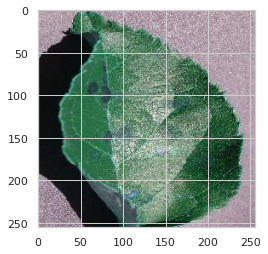

In [24]:
img = cv2.imread(new_df['Image Path'].iloc[0])
plt.imshow(img)

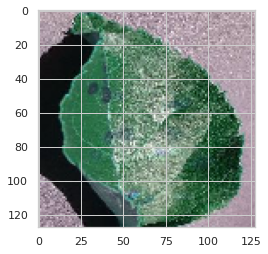

In [25]:
reshaped_img = get_reshaped_image(img)
plt.imshow(reshaped_img)

# Prepare Data

In [26]:
def transform_data(df):
    features = []
    labels = []
   
    for i, row in df.iterrows():
        img_path = row['Image Path']
        cat = row['Is Healthy']

        try:
            img = cv2.imread(img_path)

            if img is None:
                continue
             
            resized_image = get_reshaped_image(img)

            features.append(resized_image)
            label = [0.0, 0.0]
            label[cat] = 1.0
            labels.append(label)
            
            if i != 0 and i % 1000 == 0:
                print("Processed Images: ",i)
        except:
            print(f"Error in image: img_path={img_path}, cat={cat}")
            traceback.print_exc()
        
    return features, labels

    
features, labels = transform_data(new_df)
    
print(len(features))
print(len(labels))

features_2 = np.asarray(features)
print(features_2.shape)
labels_2 = np.asarray(labels)
print(labels_2.shape)

Processed Images:  1000
Processed Images:  2000
Processed Images:  3000
Processed Images:  4000
Processed Images:  5000
Processed Images:  6000
Processed Images:  7000
Processed Images:  8000
Processed Images:  9000
Processed Images:  10000
Processed Images:  11000
Processed Images:  12000
Processed Images:  13000
Processed Images:  14000
Processed Images:  15000
Processed Images:  16000
Processed Images:  17000
17457
17457
(17457, 128, 128, 3)
(17457, 2)


# Train Model

In [27]:
train_features, test_features, train_labels, test_labels = train_test_split(features_2, labels_2, test_size=0.2, random_state=1)

In [28]:
train_features.shape

(13965, 128, 128, 3)

In [29]:
test_features.shape

(3492, 128, 128, 3)

In [30]:
train_labels.shape

(13965, 2)

In [31]:
test_labels.shape

(3492, 2)

In [32]:
labels.count([0.0,1.0])

7593

In [33]:
labels.count([1.0,0.0])

9864

In [34]:
input_shape=(128,128,3)
classes = 2
epoch = 10
batch_size = 64

vgg16 = VGG16(weights=None, input_shape=input_shape, classes=classes)

# summarize the model
# vgg16.summary()

vgg16.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

early_stop= EarlyStopping(monitor='val_loss',patience=10)

mcp_save = ModelCheckpoint('mdl_vgg16_1.hdf5', save_best_only=True, monitor='val_loss', mode='min')

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                        patience=10, 
                                        verbose=1, 
                                        factor=0.5, 
                                        min_lr=0.00001)

vgg16.fit(train_features, train_labels, 
          epochs=epoch, 
          batch_size=batch_size, 
          validation_data=(test_features,test_labels), 
          callbacks=[early_stop, learning_rate_reduction])
# callbacks=[early_stop, learning_rate_reduction]
# Save the model
filepath = './vgg16_1'
save_model(vgg16, filepath)

metrics=pd.DataFrame(vgg16.history.history)
metrics

Epoch 1/10
219/219 [==============================] - 38s 153ms/step - loss: 38.4165 - accuracy: 0.5514 - val_loss: 0.6867 - val_accuracy: 0.5581
Epoch 2/10
219/219 [==============================] - 32s 145ms/step - loss: 0.6847 - accuracy: 0.5654 - val_loss: 0.6883 - val_accuracy: 0.5581
Epoch 3/10
219/219 [==============================] - 32s 145ms/step - loss: 0.6860 - accuracy: 0.5623 - val_loss: 0.6868 - val_accuracy: 0.5581
Epoch 4/10
219/219 [==============================] - 32s 145ms/step - loss: 0.6854 - accuracy: 0.5636 - val_loss: 0.6886 - val_accuracy: 0.5581
Epoch 5/10
219/219 [==============================] - 32s 145ms/step - loss: 0.6841 - accuracy: 0.5686 - val_loss: 0.6864 - val_accuracy: 0.5581
Epoch 6/10
219/219 [==============================] - 32s 145ms/step - loss: 0.6854 - accuracy: 0.5631 - val_loss: 0.6865 - val_accuracy: 0.5581
Epoch 7/10
219/219 [==============================] - 32s 145ms/step - loss: 0.6851 - accuracy: 0.5643 - val_loss: 0.6867 - val_a

,loss,accuracy,val_loss,val_accuracy,lr
0,8.344775,0.559255,0.686749,0.558133,0.001
1,0.684365,0.566774,0.688340,0.558133,0.001
2,0.684635,0.566774,0.686794,0.558133,0.001
3,0.684509,0.566774,0.688574,0.558133,0.001
4,0.684624,0.566774,0.686392,0.558133,0.001
5,0.684427,0.566774,0.686547,0.558133,0.001
6,0.684429,0.566774,0.686650,0.558133,0.001
7,0.684439,0.566774,0.686602,0.558133,0.001
8,0.684541,0.566774,0.686898,0.558133,0.001
9,0.684390,0.566774,0.686373,0.558133,0.001


In [35]:
input_shape=(128,128,3)
classes = 2
epoch = 10
batch_size = 64

resnt50 = ResNet50(weights=None, input_shape=input_shape, classes=classes)

# summarize the model
# vgg16.summary()

resnt50.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

early_stop= EarlyStopping(monitor='val_loss',patience=10)

mcp_save = ModelCheckpoint('mdl_resnt50_1.hdf5', save_best_only=True, monitor='val_loss', mode='min')

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

resnt50.fit(train_features, train_labels,
          epochs=epoch,
          batch_size=batch_size,
          validation_data=(test_features,test_labels), 
          callbacks=[early_stop, learning_rate_reduction])
# callbacks=[early_stop, learning_rate_reduction]
# Save the model
filepath = './resnt50'
save_model(resnt50, filepath)

metrics=pd.DataFrame(resnt50.history.history)
metrics

Epoch 1/10
219/219 [==============================] - 36s 138ms/step - loss: 1.0371 - accuracy: 0.7357 - val_loss: 1.1433 - val_accuracy: 0.6475
Epoch 2/10
219/219 [==============================] - 28s 129ms/step - loss: 0.2785 - accuracy: 0.8853 - val_loss: 1.2196 - val_accuracy: 0.6710
Epoch 3/10
219/219 [==============================] - 28s 129ms/step - loss: 0.2001 - accuracy: 0.9189 - val_loss: 5.7706 - val_accuracy: 0.7019
Epoch 4/10
219/219 [==============================] - 28s 129ms/step - loss: 0.1491 - accuracy: 0.9419 - val_loss: 0.7462 - val_accuracy: 0.8078
Epoch 5/10
219/219 [==============================] - 28s 129ms/step - loss: 0.1151 - accuracy: 0.9572 - val_loss: 4.8649 - val_accuracy: 0.5639
Epoch 6/10
219/219 [==============================] - 28s 129ms/step - loss: 0.0994 - accuracy: 0.9635 - val_loss: 0.5670 - val_accuracy: 0.7901
Epoch 7/10
219/219 [==============================] - 28s 129ms/step - loss: 0.0825 - accuracy: 0.9707 - val_loss: 0.5760 - val_ac

,loss,accuracy,val_loss,val_accuracy,lr
0,0.581991,0.807590,1.143275,0.647480,0.001
1,0.257007,0.895238,1.219612,0.670962,0.001
2,0.196550,0.920372,5.770569,0.701890,0.001
3,0.146317,0.943430,0.746240,0.807846,0.001
4,0.103295,0.959757,4.864929,0.563860,0.001
5,0.108970,0.959613,0.567015,0.790092,0.001
6,0.075186,0.972646,0.575987,0.808419,0.001
7,0.107251,0.960115,0.170997,0.928121,0.001
8,0.046169,0.983029,0.466070,0.891180,0.001
9,0.045782,0.982385,0.228625,0.926690,0.001


In [36]:
input_shape=(128,128,3)
classes = 2
epoch = 10
batch_size = 64

inception_v3 = InceptionV3(weights=None, input_shape=input_shape, classes=classes)

# summarize the model
# vgg16.summary()

inception_v3.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

early_stop= EarlyStopping(monitor='val_loss',patience=10)

mcp_save = ModelCheckpoint('mdl_inception_v3_1.hdf5', save_best_only=True, monitor='val_loss', mode='min')

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

inception_v3.fit(train_features, train_labels,
          epochs=epoch,
          batch_size=batch_size,
          validation_data=(test_features,test_labels), 
          callbacks=[early_stop, learning_rate_reduction])
# callbacks=[early_stop, learning_rate_reduction]
# Save the model
filepath = './inception_v3'
save_model(inception_v3, filepath)

metrics=pd.DataFrame(inception_v3.history.history)
metrics

Epoch 1/10
219/219 [==============================] - 34s 124ms/step - loss: 0.5113 - accuracy: 0.7829 - val_loss: 0.8118 - val_accuracy: 0.6790
Epoch 2/10
219/219 [==============================] - 25s 113ms/step - loss: 0.2025 - accuracy: 0.9209 - val_loss: 0.3582 - val_accuracy: 0.8674
Epoch 3/10
219/219 [==============================] - 25s 113ms/step - loss: 0.1478 - accuracy: 0.9416 - val_loss: 0.1277 - val_accuracy: 0.9576
Epoch 4/10
219/219 [==============================] - 25s 113ms/step - loss: 0.0945 - accuracy: 0.9669 - val_loss: 0.0799 - val_accuracy: 0.9711
Epoch 5/10
219/219 [==============================] - 25s 113ms/step - loss: 0.0901 - accuracy: 0.9667 - val_loss: 0.2059 - val_accuracy: 0.9135
Epoch 6/10
219/219 [==============================] - 25s 113ms/step - loss: 0.0609 - accuracy: 0.9771 - val_loss: 0.1562 - val_accuracy: 0.9550
Epoch 7/10
219/219 [==============================] - 25s 113ms/step - loss: 0.0874 - accuracy: 0.9670 - val_loss: 0.0904 - val_ac

,loss,accuracy,val_loss,val_accuracy,lr
0,0.356272,0.849910,0.811818,0.678981,0.001
1,0.188916,0.928607,0.358247,0.867411,0.001
2,0.127059,0.950877,0.127697,0.957617,0.001
3,0.091876,0.965414,0.079916,0.971077,0.001
4,0.077414,0.971429,0.205852,0.913517,0.001
5,0.059126,0.978518,0.156212,0.955040,0.001
6,0.064885,0.977014,0.090381,0.971077,0.001
7,0.042292,0.985464,0.066597,0.978522,0.001
8,0.043494,0.984318,0.176066,0.931558,0.001
9,0.042281,0.985034,0.067342,0.980813,0.001


In [37]:
results = vgg16.evaluate(test_features,test_labels)
print(f"test acc = {results[1]}\ntest loss = {results[0]}")

110/110 [==============================] - 3s 24ms/step - loss: 0.6864 - accuracy: 0.5581
test acc = 0.5581328868865967
test loss = 0.6863730549812317


In [38]:
results = resnt50.evaluate(test_features,test_labels)
print(f"test acc = {results[1]}\ntest loss = {results[0]}")

110/110 [==============================] - 3s 24ms/step - loss: 0.2286 - accuracy: 0.9267
test acc = 0.9266895651817322
test loss = 0.22862553596496582


In [39]:
results = inception_v3.evaluate(test_features,test_labels)
print(f"test acc = {results[1]}\ntest loss = {results[0]}")

110/110 [==============================] - 3s 25ms/step - loss: 0.0673 - accuracy: 0.9808
test acc = 0.9808132648468018
test loss = 0.06734218448400497


### Observation
We can see that ResNet50 and InceptionV3 are performin better. We will move forward with ResNet50.